In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
# Define path to images
image_folder = r"C:\Users\jingc\DSA4262_Health5\data\images"

# Define distances and angles for GLCM
distances = [1]  # Can be modified
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0°, 45°, 90°, 135°

# Define texture properties
properties = ['contrast', 'correlation', 'energy', 'homogeneity']

# Initialize results storage
results = []

# Process each image
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):
        img_path = os.path.join(image_folder, filename)
        
        # Load image and convert to grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Compute GLCM
        glcm = graycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

        # Extract features
        feature_vector = [filename]
        for prop in properties:
            for angle in range(len(angles)):
                feature_vector.append(graycoprops(glcm, prop)[0, angle])

        results.append(feature_vector)

# Create DataFrame and save
columns = ['Filename'] + [f"{prop}_{int(angle*180/np.pi)}deg" for prop in properties for angle in range(len(angles))]
df = pd.DataFrame(results, columns=columns)

# Save to CSV
output_csv = os.path.join(image_folder, "glcm_features.csv")
df.to_csv(output_csv, index=False)

print(f"Processed {len(results)} images. Features saved to {output_csv}.")

Processed 1003 images. Features saved to C:\Users\jingc\DSA4262_Health5\data\images\glcm_features.csv.


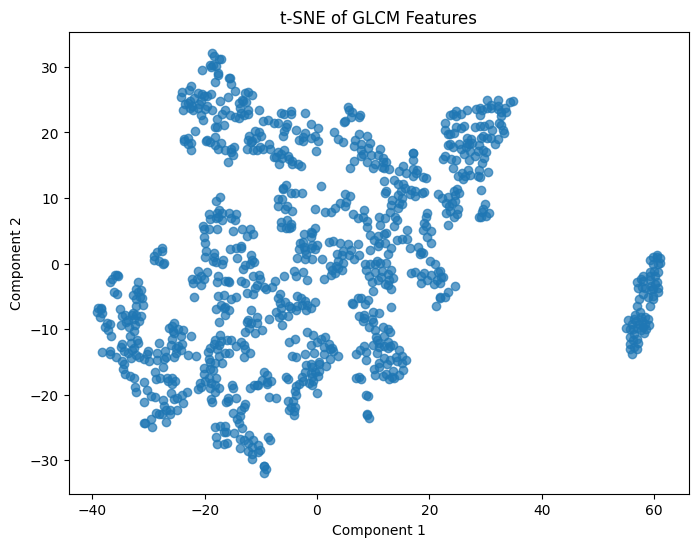

t-SNE results saved to: C:\Users\jingc\DSA4262_Health5\data\images\tsne_glcm_features.csv


In [26]:
# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df.iloc[:, 1:].values)  # Normalize all columns except Filename

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result_glcm = tsne.fit_transform(features_scaled)

# Plot t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result_glcm[:, 0], tsne_result_glcm[:, 1], alpha=0.7)
plt.title("t-SNE of GLCM Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# Save the t-SNE results
tsne_df = pd.DataFrame(tsne_result_glcm, columns=['Component 1', 'Component 2'])
tsne_df.insert(0, 'Filename', df.iloc[:, 0])  # Add filename column back
tsne_df.to_csv(os.path.join(image_folder, "tsne_glcm_features.csv"), index=False)

print("t-SNE results saved to:", os.path.join(image_folder, "tsne_glcm_features.csv"))


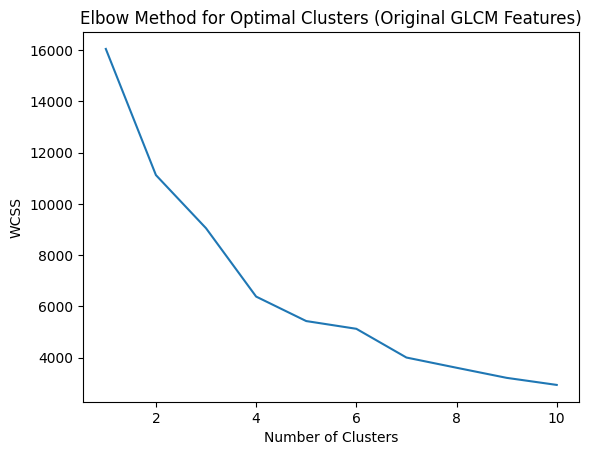

In [27]:
# Elbow Method for Optimal Clusters (on original GLCM features)
wcss_glcm = []
for i in range(1, 11):  # Test for clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)  # Fit on the original GLCM features
    wcss_glcm.append(kmeans.inertia_)  # Inertia (WCSS)

# Plot the elbow graph for original GLCM features
plt.plot(range(1, 11), wcss_glcm)
plt.title('Elbow Method for Optimal Clusters (Original GLCM Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


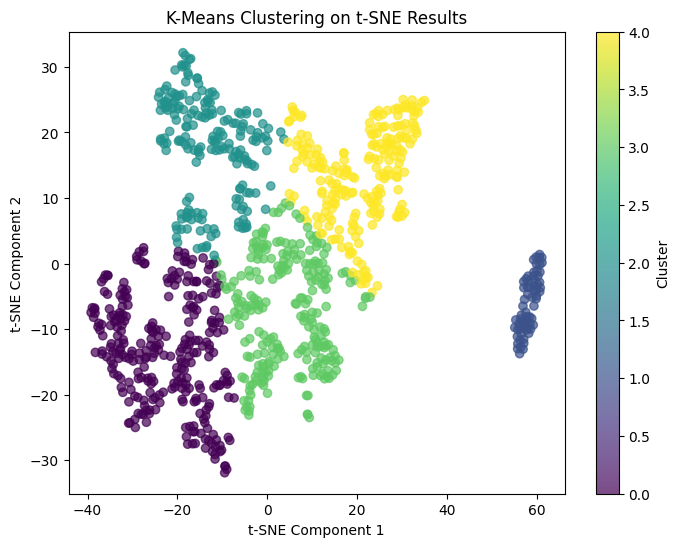

In [28]:
from sklearn.cluster import KMeans

# Apply K-Means clustering to the t-SNE result
kmeans_tsne = KMeans(n_clusters=5, random_state=42)  # Use the optimal number of clusters (e.g., 4 clusters)
kmeans_tsne.fit(tsne_result_glcm)  # Fit the K-Means on the t-SNE result

# Get the labels (cluster assignments)
tsne_labels = kmeans_tsne.labels_

# Plot the t-SNE results with the clusters
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result_glcm[:, 0], tsne_result_glcm[:, 1], c=tsne_labels, cmap='viridis', alpha=0.7)
plt.title("K-Means Clustering on t-SNE Results")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Cluster')
plt.show()


In [32]:
from sklearn.feature_selection import VarianceThreshold

# Apply VarianceThreshold to remove features with low variance
selector = VarianceThreshold(threshold=0.1)  # Threshold can be adjusted
features_selected = selector.fit_transform(df.iloc[:, 1:].values)

# Identify important features (those that were kept)
selected_features = df.columns[1:][selector.get_support()]

# Print the selected features
print("Selected Features based on Variance Threshold:", selected_features)


Selected Features based on Variance Threshold: Index(['contrast_0deg', 'contrast_57deg', 'contrast_114deg', 'contrast_171deg',
       'Cluster'],
      dtype='object')


Selected Features based on Variance Threshold: Index(['Cluster'], dtype='object')


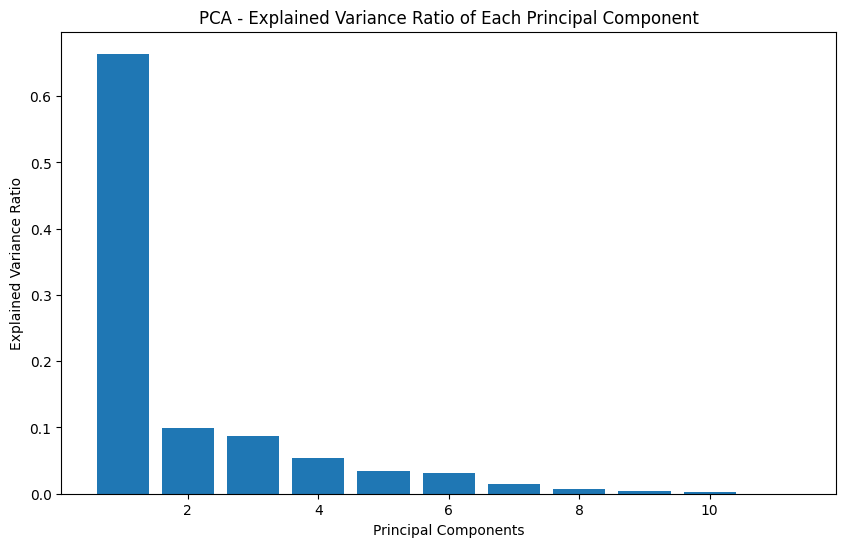

In [5]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your data
df = pd.read_csv('clustered_lbp_features.csv')

# 2. Apply Variance Threshold to remove features with low variance
selector = VarianceThreshold(threshold=0.1)  # Threshold can be adjusted
features_selected = selector.fit_transform(df.iloc[:, 1:].values)  # Assuming first column is 'Filename'

# Identify important features (those that were kept)
selected_features = df.columns[1:][selector.get_support()]

print("Selected Features based on Variance Threshold:", selected_features)

# 3. Perform PCA (Principal Component Analysis) to check variance explained by each feature
features_scaled = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()) / df.iloc[:, 1:].std()  # Standardizing data

pca = PCA(n_components=features_scaled.shape[1])  # Set components equal to number of features
pca_result = pca.fit_transform(features_scaled)

# Plot the explained variance ratio to see the importance of each principal component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Explained Variance Ratio of Each Principal Component')
plt.show()


Loadings for Principal Component 1 (PC1):
0         -0.359472
1         -0.304637
2          0.354872
3          0.362233
4          0.361300
5          0.356080
6          0.341272
7          0.302403
8          0.115761
9          0.071029
Cluster   -0.192714
Name: PC1, dtype: float64


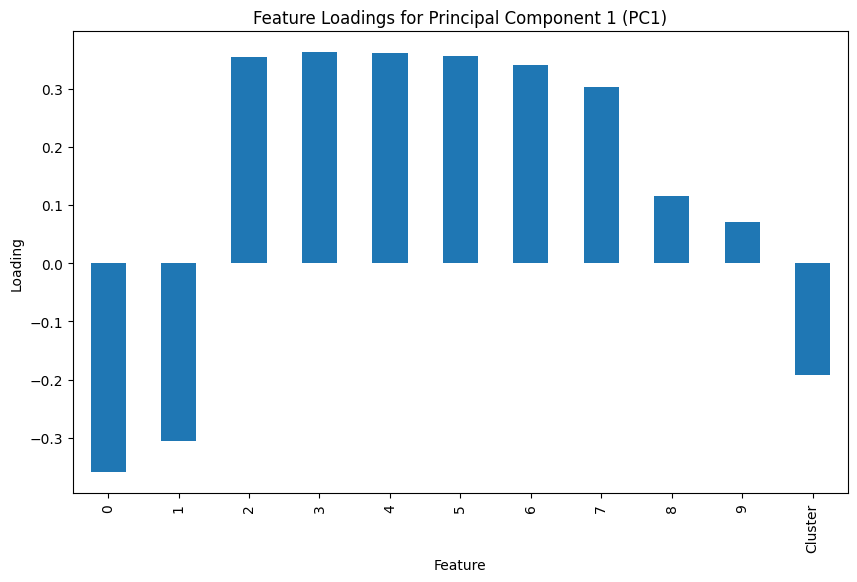

In [6]:
# Get the component loadings (how much each feature contributes to each principal component)
loadings = pca.components_

# Create a DataFrame to display the features and their corresponding loadings for each principal component
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=df.columns[1:])

# Display the loadings for the first principal component (PC1)
print("Loadings for Principal Component 1 (PC1):")
print(loadings_df['PC1'])

# Optional: Visualize the loadings for PC1
loadings_df['PC1'].plot(kind='bar', figsize=(10, 6))
plt.title('Feature Loadings for Principal Component 1 (PC1)')
plt.xlabel('Feature')
plt.ylabel('Loading')
plt.show()


In [ ]:
####################################################################################

In [37]:
import os
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from skimage import io, color
from skimage.transform import resize

In [40]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

# Define image directory and output LBP image directory
img_dir = "C:/Users/jingc/DSA4262_Health5/data/images"
lbp_img_dir = "C:/Users/jingc/DSA4262_Health5/data/lbp_images"

# Create LBP image directory if it doesn't exist
os.makedirs(lbp_img_dir, exist_ok=True)

# LBP parameters
radius = 1  # Radius for LBP
n_points = 8 * radius  # Number of points in LBP pattern

# Process each image in the directory
for filename in os.listdir(img_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
        img_path = os.path.join(img_dir, filename)

        # Load image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            # Compute LBP
            lbp = local_binary_pattern(img, n_points, radius, method="uniform")

            # Normalize LBP to range [0, 255] for visualization
            lbp_image = np.uint8(lbp * 255 / np.max(lbp))

            # Save the LBP image
            lbp_image_path = os.path.join(lbp_img_dir, f"lbp_{filename}")
            cv2.imwrite(lbp_image_path, lbp_image)

print(f"LBP images saved to: {lbp_img_dir}")


LBP images saved to: C:/Users/jingc/DSA4262_Health5/data/lbp_images


In [42]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage.feature import local_binary_pattern

# Define directories
img_dir = "C:/Users/jingc/DSA4262_Health5/data/lbp_images"
csv_path = "C:/Users/jingc/DSA4262_Health5/data/lbp_features.csv"

# LBP parameters
radius = 1  # Radius for LBP
n_points = 8 * radius  # Number of points in LBP pattern

# Initialize list for feature storage
feature_list = []
filenames = []

# Process each image in the LBP images directory
for filename in os.listdir(img_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
        img_path = os.path.join(img_dir, filename)

        # Load LBP image
        lbp_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if lbp_img is not None:
            # Compute LBP histogram
            hist, _ = np.histogram(lbp_img.ravel(), bins=np.arange(0, n_points + 3), density=True)

            # Store filename and features
            filenames.append(filename)
            feature_list.append(hist)

# Convert feature list to DataFrame
df = pd.DataFrame(feature_list)
df.insert(0, "Filename", filenames)  # Insert filename column

# Save to CSV
df.to_csv(csv_path, index=False)
print(f"LBP features saved to: {csv_path}")


LBP features saved to: C:/Users/jingc/DSA4262_Health5/data/lbp_features.csv


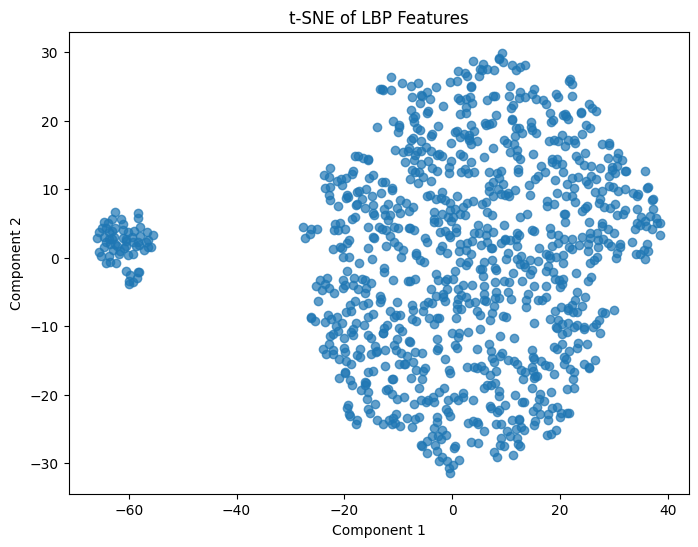

t-SNE results saved to: C:/Users/jingc/DSA4262_Health5/data/lbp_images\tsne_lbp_features.csv


In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load extracted LBP features from CSV
df = pd.read_csv(csv_path)
features = df.iloc[:, 1:].values  # Exclude Filename column

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features_scaled)

# Plot t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)
plt.title("t-SNE of LBP Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# Save the t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])
tsne_df.insert(0, 'Filename', df.iloc[:, 0])  # Add filename column back
tsne_df.to_csv(os.path.join(img_dir, "tsne_lbp_features.csv"), index=False)

print("t-SNE results saved to:", os.path.join(img_dir, "tsne_lbp_features.csv"))


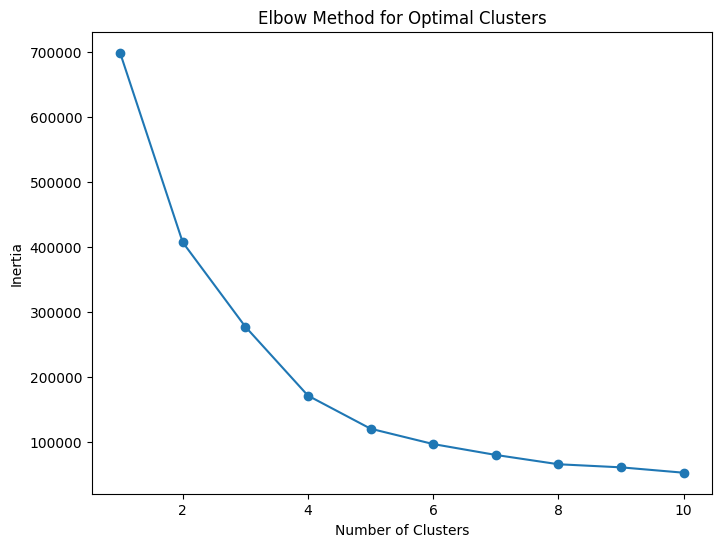

In [44]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Range of possible cluster counts
range_n_clusters = range(1, 11)

# Initialize a list to store inertia values
inertia_values = []

# Loop through the possible number of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(tsne_result)  # Use t-SNE components for clustering
    inertia_values.append(kmeans.inertia_)

# Plot inertia vs. number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


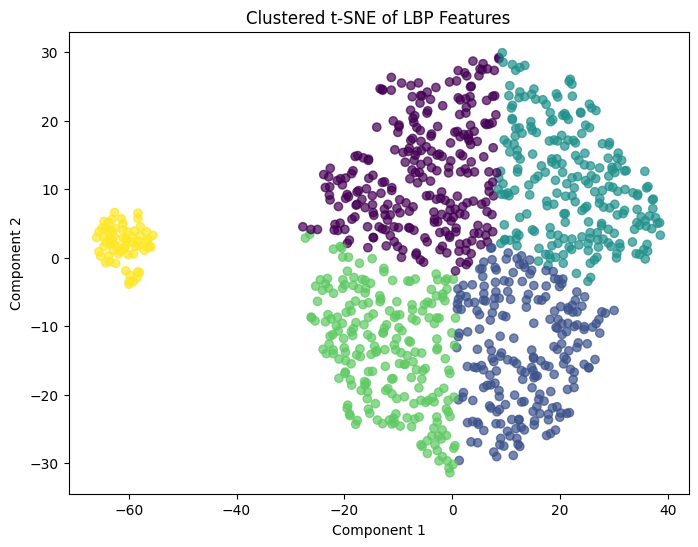

Clustered results saved to: C:/Users/jingc/DSA4262_Health5/data/lbp_images\clustered_lbp_features.csv


In [45]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(tsne_result)

# Plot clustered t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.title("Clustered t-SNE of LBP Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# Save the clustered results
df.to_csv(os.path.join(img_dir, "clustered_lbp_features.csv"), index=False)
print("Clustered results saved to:", os.path.join(img_dir, "clustered_lbp_features.csv"))


In [46]:
import numpy as np
import pandas as pd

# Assuming df is your original dataframe with features
features = df.iloc[:, 1:].values  # Exclude filename column

# Calculate variance for each feature
feature_variance = np.var(features, axis=0)

# Create a dataframe to rank features by variance
feature_importance = pd.DataFrame({
    'Feature': df.columns[1:],  # Assuming first column is filename
    'Variance': feature_variance
})

# Sort by variance in descending order
feature_importance = feature_importance.sort_values(by='Variance', ascending=False)

# Print ranked feature importance
print(feature_importance)


    Feature      Variance
10  Cluster  1.596439e+00
0         0  5.881983e-05
3         3  1.075819e-05
2         2  8.655192e-06
4         4  3.599520e-06
1         1  3.223740e-06
5         5  5.977545e-07
6         6  6.325559e-08
7         7  5.394308e-09
8         8  4.621754e-10
9         9  4.277395e-11
